In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets

torch.manual_seed(1)
import matplotlib.pyplot as plt
%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/base-2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Softmax
$softmax(x) = \frac{exp(x_i)}{\sum_j exp(x_j)}$

In [3]:
z = torch.Tensor([2.0, 1.0, 0.1])

def softmax(z):
    exps = torch.exp(z)
    return exps / torch.sum(exps)

print(softmax(z))
print(torch.sum(softmax(z)))
print("")

res = F.softmax(Variable(z), 0)
print(res)
print(torch.sum(res))

tensor([0.6590, 0.2424, 0.0986])
tensor(1.0000)

tensor([0.6590, 0.2424, 0.0986])
tensor(1.0000)


### Cross Entroy
$H(p,q)=-\sum_xp(x)logq(x)$

In [5]:
predict_1 = torch.Tensor([0.7, 0.2, 0.1])
predict_2 = torch.Tensor([0.01, 0.9, 0.99])

target = torch.Tensor([1.0, 0.0, 0.0])

def cross_entropy(q, p):
    return -torch.sum(p*torch.log(q))

print(cross_entropy(predict_1, target)) # 옳게 예측 => low loss
print(cross_entropy(predict_2, target)) # 틀리게 예측 => high loss

# in practical
predict_1  = torch.Tensor([2., 1., 0.1])
predict_2 = torch.Tensor([1., 2., 0.1])
target = torch.LongTensor([0])

loss_function = nn.CrossEntropyLoss() # softmax 연산을 포함하고 있음
loss1 = loss_function(Variable(predict_1).view(1, -1), Variable(target))
loss2 = loss_function(Variable(predict_2).view(1, -1), Variable(target))

print(loss1.item())
print(loss2.item())


tensor(0.3567)
tensor(4.6052)
0.4170299470424652
1.4170299768447876


### MNIST dataset

In [9]:
from torchvision.datasets import MNIST
train_dataset = vdatasets.MNIST(root='../../data/MNIST/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.MNIST(root='../../data/MNIST/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 31129330.51it/s]


Extracting ../../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34267523.01it/s]


Extracting ../../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6643022.60it/s]


Extracting ../../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 992111.70it/s]

Extracting ../../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/MNIST/raw



In [10]:
print(train_dataset[0][0].size())
print(train_dataset[0][1])

torch.Size([1, 28, 28])
5


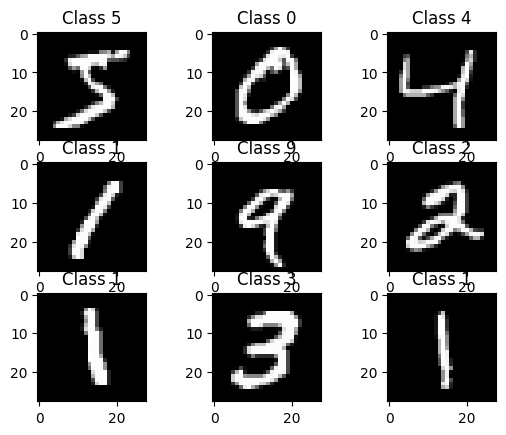

In [11]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_dataset[i][1]))

### 모델링

In [13]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs):
        outputs = F.relu(self.l1(inputs))
        return self.l2(outputs)

In [14]:
EPOCH=5
LR=0.01
BATCH_SIZE=64

model = NN(784, 512, 10)
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.SGD(model.parameters(), lr=LR)

$loss(x, class) = -log(exp(x[class]) / (\sum_j exp(x[j]))) = -x[class] + log(\sum_j exp(x[j]))$

### 트레이닝

In [15]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs).view(-1,784), Variable(targets)
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 100 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch, EPOCH, i, len(train_loader), np.mean(losses)))
            losses=[]

[0/5] [000/938] mean_loss : 2.313
[0/5] [100/938] mean_loss : 2.180
[0/5] [200/938] mean_loss : 1.905
[0/5] [300/938] mean_loss : 1.568
[0/5] [400/938] mean_loss : 1.255
[0/5] [500/938] mean_loss : 1.011
[0/5] [600/938] mean_loss : 0.845
[0/5] [700/938] mean_loss : 0.746
[0/5] [800/938] mean_loss : 0.688
[0/5] [900/938] mean_loss : 0.626
[1/5] [000/938] mean_loss : 0.478
[1/5] [100/938] mean_loss : 0.563
[1/5] [200/938] mean_loss : 0.550
[1/5] [300/938] mean_loss : 0.504
[1/5] [400/938] mean_loss : 0.480
[1/5] [500/938] mean_loss : 0.480
[1/5] [600/938] mean_loss : 0.460
[1/5] [700/938] mean_loss : 0.436
[1/5] [800/938] mean_loss : 0.436
[1/5] [900/938] mean_loss : 0.433
[2/5] [000/938] mean_loss : 0.483
[2/5] [100/938] mean_loss : 0.409
[2/5] [200/938] mean_loss : 0.393
[2/5] [300/938] mean_loss : 0.403
[2/5] [400/938] mean_loss : 0.390
[2/5] [500/938] mean_loss : 0.388
[2/5] [600/938] mean_loss : 0.384
[2/5] [700/938] mean_loss : 0.363
[2/5] [800/938] mean_loss : 0.383
[2/5] [900/938

### 테스트

In [16]:
num_equal=0
for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = Variable(inputs).view(-1,784), Variable(targets)
    outputs = model(inputs)
    
    outputs = outputs.max(1)[1] # argmax
    num_equal += torch.eq(outputs, targets).sum().item() # eq: 같으면 True
    
print("Accuracy : " ,num_equal/len(test_dataset))

Accuracy :  0.9167
